In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam

# Constants
IMG_SIZE = (128, 128)  # Image size for preprocessing
INPUT_DIR = '/kaggle/input/liver-tumor-segmentation'  # Dataset directory
BATCH_SIZE = 8  # Batch size for training
EPOCHS = 20  # Number of epochs to train for


# Function to load and preprocess data
def load_and_preprocess_data(df, img_size=IMG_SIZE, limit=20):
    images, masks = [], []

    for i in tqdm(range(min(len(df), limit)), desc="Loading Data"):
        img_path = os.path.join(df['dirname'].iloc[i], df['filename'].iloc[i])
        mask_path = os.path.join(df['mask_dirname'].iloc[i], df['mask_filename'].iloc[i])

        img_nii = nib.load(img_path)
        mask_nii = nib.load(mask_path)

        img_data = img_nii.get_fdata()
        mask_data = mask_nii.get_fdata()

        # Process slices
        slices = range(img_data.shape[2])
        for j in slices:
            img_slice = cv2.resize(img_data[:, :, j], img_size, interpolation=cv2.INTER_LINEAR)
            mask_slice = cv2.resize(mask_data[:, :, j], img_size, interpolation=cv2.INTER_NEAREST)

            # Normalize image and mask
            images.append(img_slice / 255.0)  # Normalize image to [0, 1]
            masks.append(1 if np.max(mask_slice) > 0 else 0)  # Binary mask conversion

    images = np.expand_dims(np.array(images), -1)  # Add channel dimension
    masks = np.array(masks)
    return images, masks


# Map images and masks dynamically
file_list = []
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])
df_files = df_files[df_files['filename'].str.contains("volume")]
df_files['mask_filename'] = df_files['filename'].str.replace("volume", "segmentation")
df_files['mask_dirname'] = INPUT_DIR + "/segmentations"

# Load data with preprocessed slices
images, labels = load_and_preprocess_data(df_files, limit=20)
labels = to_categorical(labels, num_classes=2)  # One-hot encode the labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the U-Net model
def create_unet_model(input_shape=IMG_SIZE + (1,)):
    """
    Function to create a standard U-Net architecture
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    merge1 = layers.Concatenate()([u1, c3])
    
    u2 = layers.UpSampling2D((2, 2))(merge1)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    merge2 = layers.Concatenate()([u2, c2])

    u3 = layers.UpSampling2D((2, 2))(merge2)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    merge3 = layers.Concatenate()([u3, c1])

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(merge3)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create U-Net model
model = create_unet_model()


Loading Data: 100%|██████████| 20/20 [02:03<00:00,  6.18s/it]
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 130s 251ms/step - accuracy: 0.8802 - loss: 0.2566 - val_accuracy: 0.9719 - val_loss: 0.0697 - learning_rate: 1.0000e-04
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 125s 247ms/step - accuracy: 0.9818 - loss: 0.0519 - val_accuracy: 0.9936 - val_loss: 0.0256 - learning_rate: 1.0000e-04
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 127s 250ms/step - accuracy: 0.9887 - loss: 0.0318 - val_accuracy: 0.9921 - val_loss: 0.0218 - learning_rate: 1.0000e-04
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 132s 259ms/step - accuracy: 0.9877 - loss: 0.0303 - val_accuracy: 0.9936 - val_loss: 0.0200 - learning_rate: 1.0000e-04
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 124s 243ms/step - accuracy: 0.9909 - loss: 0.0239 - val_accuracy: 0.9951 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 128s 252ms/step - accuracy: 0.9940 - loss: 0.0158 - val_accuracy: 0.9941 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 7/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 

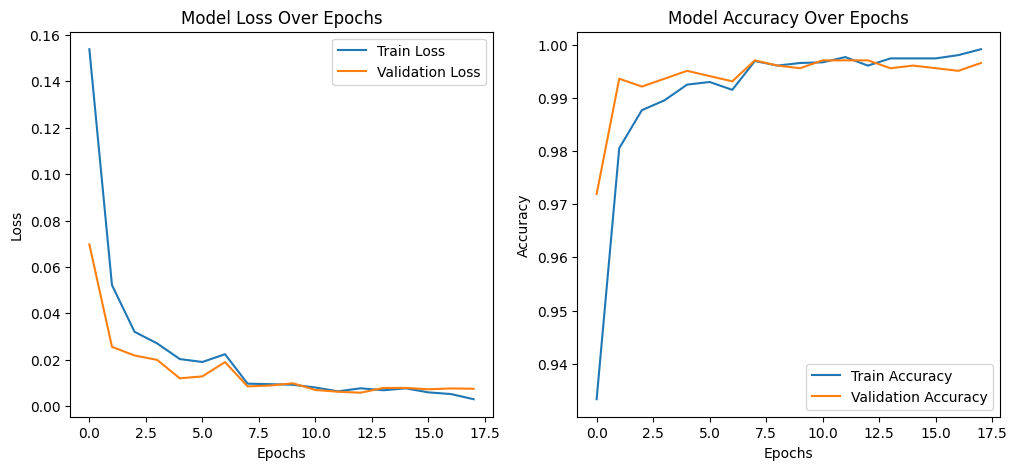

In [4]:
# Model Checkpoints
checkpoint = callbacks.ModelCheckpoint('best_unet_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='min')

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()